In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def ret_supp(point):
    x = np.arange(-10,10,.01)
    if point[0] == 0:
        m = 0
    else:
        m = -math.pow(point[1]/point[0],-1)
    print(m)
    b = point[1] + -m*point[0]
    print(b)
    y = m*x + b
    return x, y

-2.9042108776758218
-22.431032241889188


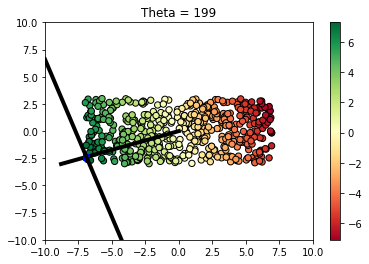

In [54]:
n = 500
U_x = np.random.uniform(-7,7,(1,n))
U_y = np.random.uniform(-3,3,(1,n))
U = np.vstack((U_x,U_y))
theta = 199
direction = np.array([np.cos(np.radians(theta)), np.sin(np.radians(theta))])
colors = [np.dot(U[:,i], direction) for i in range(n)]
scale = np.dot(U[:,np.argmax(colors)], direction)
sup_x, sup_y = ret_supp([direction[0]*scale, direction[1]*scale])
plt.title(f"Theta = {theta}")
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.scatter(U[0,:], U[1,:], c=colors, cmap="RdYlGn", s=40, edgecolors="black");
plt.plot([0,direction[0]*(scale+2)], [0, direction[1]*(scale+2)], "k", linewidth=4)
plt.plot(direction[0]*scale, direction[1]*scale, "bs")
plt.plot(sup_x, sup_y, "k", linewidth=4)
plt.colorbar()
plt.show()

In [14]:
n = 800
U_x = np.random.uniform(-7,7,(1,n))
U_y = np.random.uniform(-3,3,(1,n))
U = np.vstack((U_x,U_y))
for theta in range(0, 361):
    direction = np.array([np.cos(np.radians(theta)), np.sin(np.radians(theta))])
    colors = [np.dot(U[:,i], direction) for i in range(n)]
    scale = np.dot(U[:,np.argmax(colors)], direction)
    plt.title(f"Theta = {theta}")
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.scatter(U[0,:], U[1,:], c=colors, cmap="RdYlGn", s=40, edgecolors="black");
    plt.plot([0,direction[0]*(scale+2)], [0, direction[1]*(scale+2)], "k", linewidth=4)
    plt.plot(direction[0]*scale, direction[1]*scale, "bs")
    plt.colorbar()
    plt.savefig(f"images/theta_{theta}")
    plt.clf()
    

<Figure size 432x288 with 0 Axes>

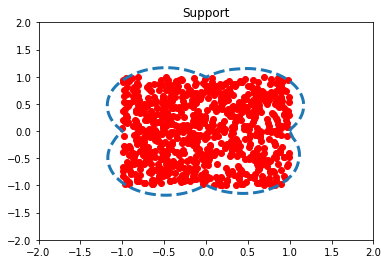

In [19]:
n = 800
U_x = np.random.uniform(-1,1,(1,n))
U_y = np.random.uniform(-1,1,(1,n))
U = np.vstack((U_x,U_y))
support_x = []
support_y = []
for theta in range(0, 361):
    direction = np.array([np.cos(np.radians(theta)), np.sin(np.radians(theta))])
    colors = [np.dot(U[:,i], direction) for i in range(n)]
    scale = np.dot(U[:,np.argmax(colors)], direction)
    support_x.append(direction[0]*scale)
    support_y.append(direction[1]*scale)
support = np.vstack((support_x, support_y))
plt.title(f"Support")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.scatter(U[0,:], U[1,:], c="red");
plt.plot(support[0,:], support[1,:], "--", linewidth=3)
plt.show()

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

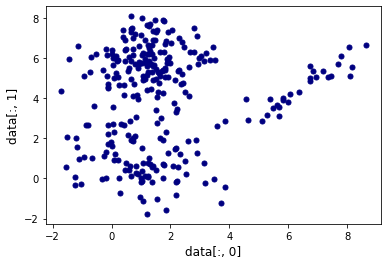

In [3]:
folder = np.load("samples.npz")
data = folder['data']
fig = plt.figure(figsize=(6,4))
plt.plot(data[:, 0], data[:, 1], linestyle='None', marker='o', markersize=5, color='navy')
plt.xlabel('data[:, 0]', fontsize=12)
plt.ylabel('data[:, 1]', fontsize=12)
plt.show()

In [5]:
pi0 = folder['pi0']
mu0 = folder['mu0']
sigma0 = folder['sigma0']

print(f'Check the shape of pi0 = ({pi0.shape}), mu0 = ({mu0.shape}), sigma0 = ({sigma0.shape})')
print(f'pi0: \n{pi0} \n mu0: \n{mu0}\n sigma0: \n{sigma0}')

Check the shape of pi0 = ((3,)), mu0 = ((3, 2)), sigma0 = ((3, 2, 2))
pi0: 
[0.3451814  0.6066179  0.04820071] 
 mu0: 
[[-0.71336192  0.90635089]
 [ 0.76623673  0.82605407]
 [-1.32368279 -1.75244452]]
 sigma0: 
[[[ 1.00490413  1.89980228]
  [ 1.89980228  4.18354574]]

 [[ 1.96867815  0.78415336]
  [ 0.78415336  1.83319942]]

 [[ 0.19316335 -0.11648642]
  [-0.11648642  1.98395967]]]


In [20]:
from scipy.stats import multivariate_normal

def E_step(data, pi, mu, sigma):
    N = data.shape[0]
    K = pi.shape[0]
    d = mu.shape[0]
    gamma = np.zeros((N,K))
    for nk in range(K):
        gamma[:, nk] = pi[nk] * multivariate_normal.pdf(data, mean=mu[nk], cov=sigma[nk])
    gamma = gamma/np.sum(gamma, axis=1, keepdims=True)
    
    return gamma

In [26]:
def M_step(data, gamma):
    N, D = data.shape
    K = gamma.shape[1]
    pi = np.zeros(K)
    mu = np.zeros((K,D))
    sigma = np.zeros((K, D, D))
    
    for ik in range(K):
        n_k = gamma[:, ik].sum()
        pi[ik] = n_k/N
        elements = np.reshape(gamma[:, ik], (gamma.shape[0], 1))
        mu[ik, :] = (np.multiply(elements, data)).sum(axis=0) / n_k
        sigma_sum = 0
        for i in range(N):
            var = data[i] - mu[ik]
            sigma_sum = sigma_sum + gamma[i, ik] * np.outer(var, var)
        sigma[ik, :] = sigma_sum/n_k
    return pi, mu, sigma

In [35]:
def elbo(data, gamma, pi, mu, sigma):
    N = data.shape[0]
    K = gamma.shape[1]
    d = data.shape[1]
    
    loss = 0
    for i in range(N):
        x = data[i]
        for k in range(K):
            pos_dist = gamma[i, k]
            log_lik = np.log(multivariate_normal.pdf(x, mean=mu[k, :], cov=sigma[k, :, :] + 1e-20))
            log_q = np.log(gamma[i, k] + 1e-20)
            log_pz = np.log(pi[k] + 1e-20)
            loss = (loss + np.multiply(pos_dist, log_pz) + np.multiply(pos_dist, log_lik) + np.multiply(pos_dist, -log_q))
    return loss

In [43]:
def train_loop(data, K, tolerance=1e-9, max_iter=50,restart=10):
    N, d = data.shape
    elbo_best = -np.inf
    pi_best = None
    mu_best = None
    sigma_best = None
    gamma_f = None
    for _ in range(restart):
        pi = np.ones(K) / K
        mu = np.random.rand(K, d)
        sigma = np.tile(np.eye(d), (K, 1, 1))
        last_iter_loss = None
        all_losses = []
        try: 
            
            for i in range(max_iter):
                gamma = E_step(data, pi, mu, sigma)
                pi, mu, sigma = M_step(data, gamma)
                loss = elbo(data, gamma, pi, mu, sigma)
                if loss > elbo_best:
                    elbo_best = loss
                    pi_best = pi
                    mu_best = mu
                    sigma_best = sigma
                    gamma_f = gamma
                if last_iter_loss and abs((loss - last_iter_loss)/last_iter_loss) < tolerance:
                    break
                last_iter_loss = loss
                all_losses.append(loss)
        except np.linalg.LinAlgError:
            pass
    return elbo_best, pi_best, mu_best, sigma_best, all_losses, gamma_f

In [44]:
best_loss, pi_best, mu_best, sigma_best, ls_lst, final_posterior = train_loop(data, 3)

In [45]:
print ("starting loss, best_loss: ", ls_lst[0], ',',  best_loss)
print ("best pi", pi_best) 
print ("best mu: ", mu_best)

print ("best sigma: ", sigma_best)

starting loss, best_loss:  -1227.9747286007416 , -1063.8112563649577
best pi [0.10731027 0.55082013 0.3418696 ]
best mu:  [[6.29621487 4.43087036]
 [1.22309922 5.83020844]
 [0.92114067 0.96661459]]
best sigma:  [[[ 1.70903802  1.39177063]
  [ 1.39177063  1.32296855]]

 [[ 0.94351626  0.06733192]
  [ 0.06733192  1.10639201]]

 [[ 1.49892275 -0.37296845]
  [-0.37296845  1.4289368 ]]]


In [52]:
def plot_contours(data, means, covs):
    """visualize the gaussian components over the data"""
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.5, 10.0, delta)
    y = np.arange(-2.5, 10.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])
    plt.tight_layout()

<Figure size 1008x864 with 0 Axes>

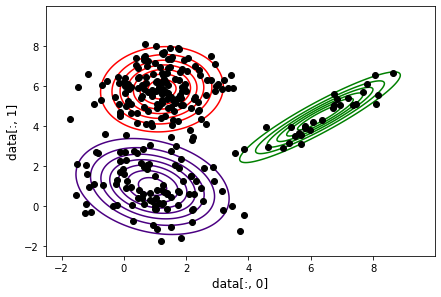

In [56]:
fig= plt.figure(figsize=(14, 12))
plot_contours(data, mu_best, sigma_best)
plt.xlabel("data[:, 0]", fontsize=12)
plt.ylabel("data[:, 1]", fontsize=12)
plt.show()

<Figure size 1008x864 with 0 Axes>

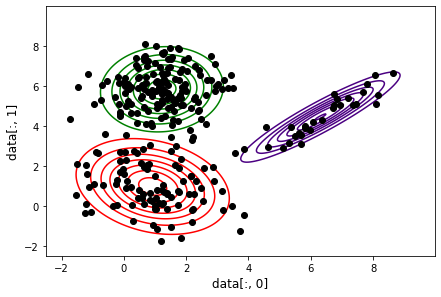

In [57]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=10)
gmm.fit(data)

fig= plt.figure(figsize=(14, 12))
plot_contours(data, gmm.means_, gmm.covariances_)
plt.xlabel("data[:, 0]", fontsize=12)
plt.ylabel("data[:, 1]", fontsize=12)
plt.show()